Demonstrates the diffusion process on 1D data, similar to what's shown in the image. This will include both the forward diffusion process (adding noise) and the reverse process (denoising).

This implementation demonstrates the key concepts shown in the image:

1. **Forward Diffusion Process**:
   - The code gradually adds noise to the original data distribution
   - Uses a noise schedule (β) that increases over time
   - Shows how the data transforms from the original bimodal distribution to Gaussian noise

2. **Reverse Diffusion Process**:
   - Implements the reverse process that tries to recover the original distribution
   - Uses a simple noise predictor (in practice, this would be a trained neural network)
   - Shows how the model can reconstruct the original distribution

Key components of the implementation:

1. `OneDimensionalDiffusion` class:
   - Handles the noise schedule and diffusion parameters
   - Implements both forward and reverse diffusion steps

2. `forward_diffusion`:
   - Adds noise according to the schedule
   - Matches the process shown in the right side of your image

3. `reverse_diffusion`:
   - Implements the denoising process
   - Uses a noise prediction model to guide the reverse process

4. Visualization functions:
   - Shows the progression of the diffusion process
   - Compares original and recovered distributions


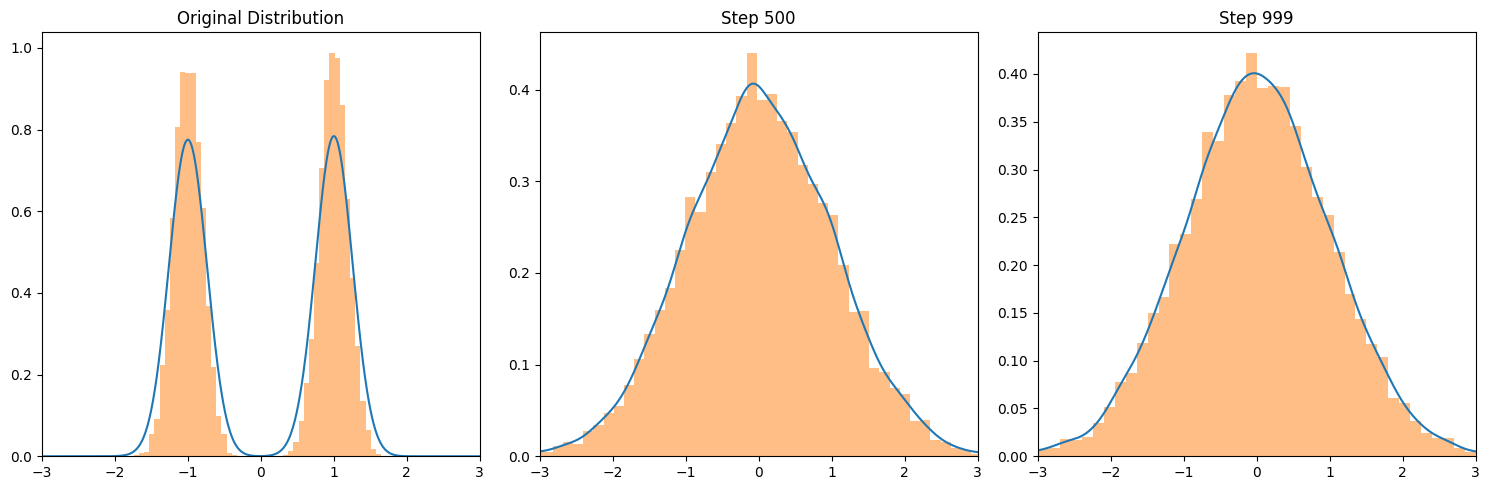

1000it [00:00, 2454.07it/s]


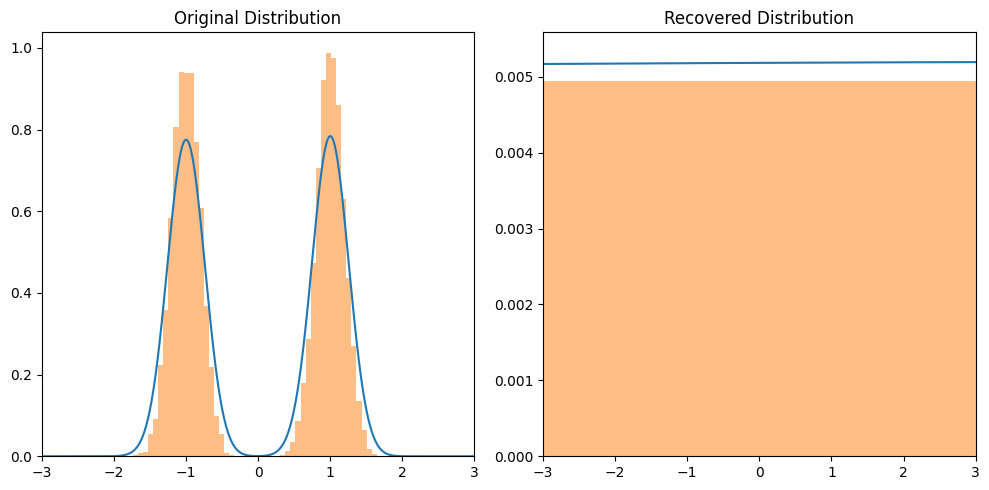

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm

class OneDimensionalDiffusion:
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02):
        """
        Initialize the 1D diffusion model.
        
        Args:
            num_timesteps: Number of diffusion steps
            beta_start: Starting noise schedule value
            beta_end: Ending noise schedule value
        """
        self.num_timesteps = num_timesteps
        
        # Define noise schedule
        self.betas = np.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = np.cumprod(self.alphas)
        self.sqrt_alphas_cumprod = np.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = np.sqrt(1 - self.alphas_cumprod)

    def forward_diffusion(self, x_0, t):
        """
        Apply forward diffusion process up to step t.
        
        Args:
            x_0: Initial data points
            t: Timestep to diffuse to
        """
        noise = np.random.normal(size=x_0.shape)
        mean = self.sqrt_alphas_cumprod[t] * x_0
        std = self.sqrt_one_minus_alphas_cumprod[t]
        return mean + std * noise

    def reverse_diffusion(self, model, x_t, t):
        """
        Single step of reverse diffusion process.
        
        Args:
            model: Noise prediction model
            x_t: Current noisy samples
            t: Current timestep
        """
        predicted_noise = model(x_t, t)
        alpha = self.alphas[t]
        alpha_cumprod = self.alphas_cumprod[t]
        beta = self.betas[t]
        
        mean = (1 / np.sqrt(alpha)) * (x_t - (beta / np.sqrt(1 - alpha_cumprod)) * predicted_noise)
        if t > 0:
            noise = np.random.normal(size=x_t.shape)
            std = np.sqrt(beta)
            return mean + std * noise
        return mean

def create_bimodal_data(n_samples=1000):
    """Create synthetic bimodal distribution."""
    samples1 = np.random.normal(-1, 0.2, n_samples // 2)
    samples2 = np.random.normal(1, 0.2, n_samples // 2)
    return np.concatenate([samples1, samples2])

def simple_noise_predictor(x_t, t):
    """
    Simple noise prediction model (this is a placeholder for demonstration).
    In practice, this would be a trained neural network.
    """
    return 0.1 * x_t  # Simplified prediction

def plot_diffusion_process(x_0, diffusion_model):
    """Visualize the diffusion process."""
    plt.figure(figsize=(15, 5))
    
    # Plot original distribution
    plt.subplot(131)
    kde = gaussian_kde(x_0)
    x_range = np.linspace(-3, 3, 1000)
    plt.plot(x_range, kde(x_range), label='Original')
    plt.hist(x_0, bins=50, density=True, alpha=0.5)
    plt.title('Original Distribution')
    plt.xlim(-3, 3)
    
    # Plot mid-diffusion
    plt.subplot(132)
    x_mid = diffusion_model.forward_diffusion(x_0, t=diffusion_model.num_timesteps//2)
    kde_mid = gaussian_kde(x_mid)
    plt.plot(x_range, kde_mid(x_range), label='Mid-diffusion')
    plt.hist(x_mid, bins=50, density=True, alpha=0.5)
    plt.title(f'Step {diffusion_model.num_timesteps//2}')
    plt.xlim(-3, 3)
    
    # Plot fully diffused
    plt.subplot(133)
    x_final = diffusion_model.forward_diffusion(x_0, t=diffusion_model.num_timesteps-1)
    kde_final = gaussian_kde(x_final)
    plt.plot(x_range, kde_final(x_range), label='Fully diffused')
    plt.hist(x_final, bins=50, density=True, alpha=0.5)
    plt.title(f'Step {diffusion_model.num_timesteps-1}')
    plt.xlim(-3, 3)
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Create synthetic data
    x_0 = create_bimodal_data(n_samples=10000)
    
    # Initialize diffusion model
    diffusion_model = OneDimensionalDiffusion()
    
    # Visualize diffusion process
    plot_diffusion_process(x_0, diffusion_model)
    
    # Demonstrate reverse diffusion
    x_T = diffusion_model.forward_diffusion(x_0, diffusion_model.num_timesteps-1)
    x_t = x_T.copy()
    
    # Reverse diffusion steps
    for t in tqdm(reversed(range(diffusion_model.num_timesteps))):
        x_t = diffusion_model.reverse_diffusion(simple_noise_predictor, x_t, t)
    
    # Plot final results
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    kde_original = gaussian_kde(x_0)
    x_range = np.linspace(-3, 3, 1000)
    plt.plot(x_range, kde_original(x_range), label='Original')
    plt.hist(x_0, bins=50, density=True, alpha=0.5)
    plt.title('Original Distribution')
    plt.xlim(-3, 3)
    
    plt.subplot(122)
    kde_recovered = gaussian_kde(x_t)
    plt.plot(x_range, kde_recovered(x_range), label='Recovered')
    plt.hist(x_t, bins=50, density=True, alpha=0.5)
    plt.title('Recovered Distribution')
    plt.xlim(-3, 3)
    
    plt.tight_layout()
    plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output

class OneDimensionalDiffusion:
    def __init__(self, num_timesteps=100, beta_start=1e-4, beta_end=0.02):  # Reduced timesteps for better widget handling
        self.num_timesteps = num_timesteps
        self.betas = np.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = np.cumprod(self.alphas)
        self.sqrt_alphas_cumprod = np.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = np.sqrt(1 - self.alphas_cumprod)
        
        # Store intermediate states for hierarchical visualization
        self.hierarchical_states = {}
    
    def forward_diffusion(self, x_0, t):
        """Apply forward diffusion and store intermediate states"""
        noise = np.random.normal(size=x_0.shape)
        mean = self.sqrt_alphas_cumprod[t] * x_0
        std = self.sqrt_one_minus_alphas_cumprod[t]
        x_t = mean + std * noise
        
        # Store state for hierarchical visualization
        self.hierarchical_states[t] = x_t.copy()
        return x_t

def create_bimodal_data(n_samples=1000, means=[-1, 1], stds=[0.2, 0.2]):
    """Create synthetic bimodal distribution with adjustable parameters"""
    samples1 = np.random.normal(means[0], stds[0], n_samples // 2)
    samples2 = np.random.normal(means[1], stds[1], n_samples // 2)
    return np.concatenate([samples1, samples2])

class DiffusionVisualizer:
    def __init__(self, n_samples=10000):
        self.n_samples = n_samples
        self.x_0 = create_bimodal_data(n_samples)
        self.diffusion_model = OneDimensionalDiffusion()
        self.x_range = np.linspace(-3, 3, 1000)
        
        # Run forward diffusion for all timesteps
        print("Running forward diffusion...")
        self.run_forward_diffusion()
        
        # Create interactive widgets
        self.create_widgets()
    
    def run_forward_diffusion(self):
        """Run forward diffusion process and store all intermediate states"""
        x_t = self.x_0.copy()
        for t in tqdm(range(self.diffusion_model.num_timesteps)):
            x_t = self.diffusion_model.forward_diffusion(self.x_0, t)
    
    def plot_hierarchical_view(self, timesteps):
        """Plot distributions at multiple timesteps in a hierarchical view"""
        n_plots = len(timesteps)
        fig, axes = plt.subplots(1, n_plots, figsize=(15, 4))
        if n_plots == 1:
            axes = [axes]
            
        for i, t in enumerate(timesteps):
            x_t = self.diffusion_model.hierarchical_states[t]
            kde = gaussian_kde(x_t)
            
            axes[i].plot(self.x_range, kde(self.x_range), 'b-', label=f't={t}')
            axes[i].hist(x_t, bins=50, density=True, alpha=0.3)
            axes[i].set_title(f'Step {t}')
            axes[i].set_xlim(-3, 3)
            axes[i].set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
    
    def create_widgets(self):
        """Create interactive widgets for visualization"""
        # Create sliders for start and end timesteps
        self.start_slider = widgets.IntSlider(
            value=0,
            min=0,
            max=self.diffusion_model.num_timesteps-1,
            description='Start step:',
            continuous_update=False
        )
        
        self.end_slider = widgets.IntSlider(
            value=self.diffusion_model.num_timesteps-1,
            min=0,
            max=self.diffusion_model.num_timesteps-1,
            description='End step:',
            continuous_update=False
        )
        
        self.n_steps_slider = widgets.IntSlider(
            value=5,
            min=2,
            max=10,
            description='# Views:',
            continuous_update=False
        )
        
        # Create update button
        self.update_button = widgets.Button(
            description='Update View',
            button_style='primary'
        )
        self.update_button.on_click(self.update_plot)
        
        # Display widgets
        display(widgets.VBox([
            self.start_slider,
            self.end_slider,
            self.n_steps_slider,
            self.update_button
        ]))
        
        # Initial plot
        self.update_plot(None)
    
    def update_plot(self, _):
        """Update the plot based on widget values"""
        start = self.start_slider.value
        end = self.end_slider.value
        
        # Ensure start is less than end
        if start > end:
            start, end = end, start
        
        n_steps = self.n_steps_slider.value
        
        # Generate evenly spaced timesteps between start and end
        selected_timesteps = np.linspace(start, end, n_steps, dtype=int)
        
        clear_output(wait=True)
        # Redisplay widgets
        display(widgets.VBox([
            self.start_slider,
            self.end_slider,
            self.n_steps_slider,
            self.update_button
        ]))
        
        # Plot new view
        self.plot_hierarchical_view(selected_timesteps)

# Function to run the visualization
def run_visualization():
    print("Initializing visualization...")
    return DiffusionVisualizer()

# To use in Jupyter notebook:
# visualizer = run_visualization()

  0%|          | 0/1000 [00:00<?, ?it/s]

TraitError: Invalid selection: value not found